# Focused, defocused and residually-defocused images for neural network training

This Jupyter notebook generates focused, defocused and residually-defocused depth migrated images for CNN training for both fault segmentation as well as focused image classification

## Import the necessary modules

In [1]:
import os, wget
import numpy as np
# Wave propagation module
import scaas.defaultgeom as geom
from scaas.wavelet import ricker
from scaas.trismooth import smooth
# Creating velocity models and perturbations
from velocity.stdmodels import undulatingrandfaults2d
from scaas.velocity import create_randomptbs_loc
# Residual migration
from resfoc.resmig import preresmig, convert2time, get_rho_axis
# Modules for labeling the images
from deeplearn.utils import normextract
from deeplearn.focuslabels import corrsim, semblance_power
import tensorflow as tf
from tensorflow.keras.models import model_from_json
# Plotting utilities
from resfoc.gain import agc
from deeplearn.utils import plotseglabel
from utils.plot import plot_imgvelptb, plot_wavelet, plot_cubeiso
import matplotlib.pyplot as plt
# Verbosity
from utils.ptyprint import progressbar

/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/sep/joseph29/anaconda3/envs/tf-gpu/lib/pyt

## Create the random velocity model

ndeposit: [########################################] 21/21
nsfaults: [########################################] 6/6


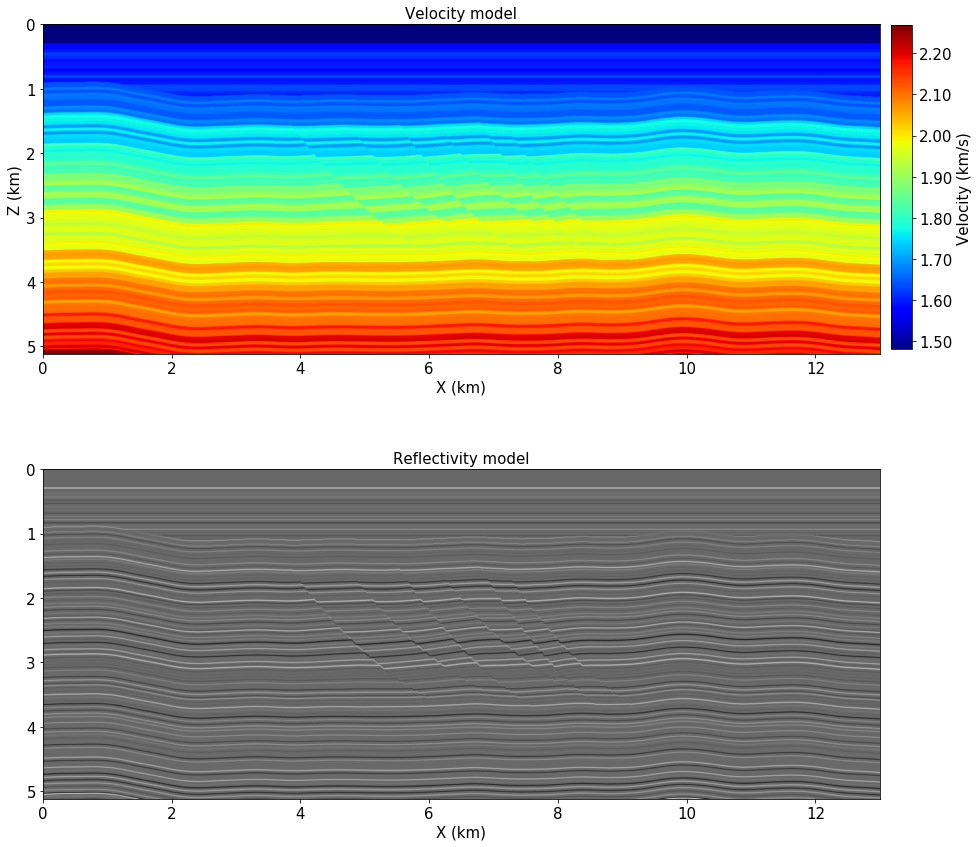

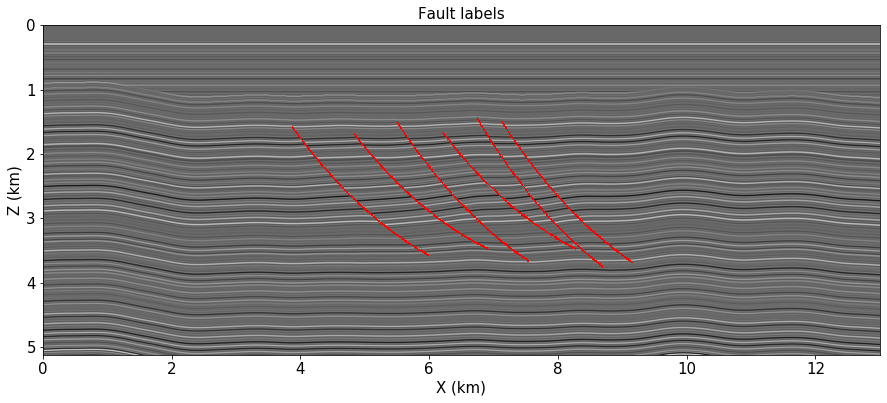

In [2]:
# Create a undulating model with faults at the center
# NOTE: each time this runs, a different random model will be generated
nx = 1300; nz = 512; nh = 16; na = 64
vel,ref,cnv,lbl = undulatingrandfaults2d(nz=nz,nx=nx,ofx=0.4,dfx=0.08)
dx = 10; dz = 10; dh = 10
dxp = dx/1000.0; dzp = dz/1000.0

fsize = 15
fig,ax = plt.subplots(2,1,figsize=(15,15))
im = ax[0].imshow(vel/1000.0,cmap='jet',interpolation='bilinear',extent=[0,(nx)*dxp,(nz)*dzp,0])
ax[0].set_ylabel('Z (km)',fontsize=fsize)
ax[0].set_xlabel('X (km)',fontsize=fsize)
ax[0].set_title('Velocity model',fontsize=fsize)
ax[0].tick_params(labelsize=fsize)
cbar_ax = fig.add_axes([0.91,0.56,0.02,0.3])
cbar = fig.colorbar(im,cbar_ax,format='%.2f')
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('Velocity (km/s)',fontsize=fsize)
ax[1].imshow(ref,cmap='gray',interpolation='bilinear',extent=[0,(nx)*dxp,(nz)*dzp,0])
ax[1].set_xlabel('X (km)',fontsize=fsize)
ax[1].set_title('Reflectivity model',fontsize=fsize)
ax[1].tick_params(labelsize=fsize)
# Plot fault label on reflectivity and image
plotseglabel(ref,lbl,show=True,interpolation='bilinear',labelsize=fsize,ticksize=fsize,xlabel='X (km)',ylabel='Z (km)',
             wbox=15,hbox=7,xmin=0,xmax=dxp*nx,zmin=0,zmax=dzp*nz,title='Fault labels')

## Create migration velocity, velocity perturbation and modeling velocity

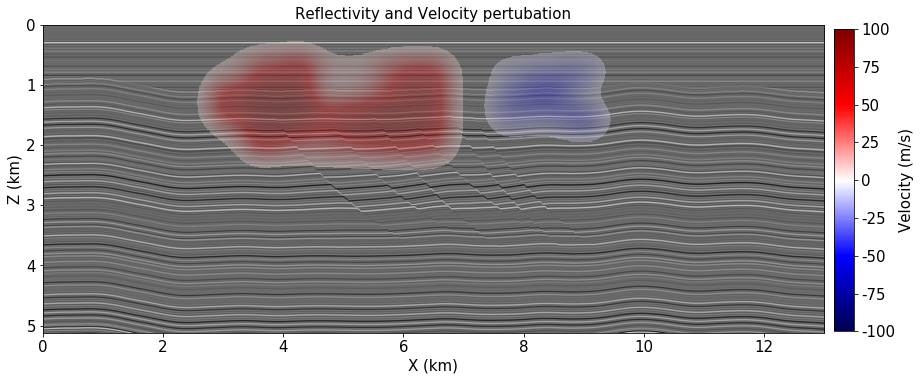

In [3]:
# Create migration velocity
velmig = smooth(vel,rect1=30,rect2=30)

# Create a random perturbation
ano = create_randomptbs_loc(nz,nx,nptbs=3,romin=0.95,romax=1.05,
                            minnaz=100,maxnaz=150,minnax=100,maxnax=400,mincz=100,maxcz=150,mincx=300,maxcx=900,
                            mindist=100,nptsz=2,nptsx=2,octaves=2,period=80,persist=0.2,ncpu=1,sigma=20)

# Create velocity with anomaly
veltru = velmig*ano
velptb = veltru - velmig

# Plot the velocity anomaly on the reflectivity
plot_imgvelptb(ref,velptb,dz,dx,velmin=-100,velmax=100,thresh=5,agc=False,
               show=True,hbar=0.6,barz=0.2,wbox=14,hbox=7,title='Reflectivity and Velocity pertubation')

## Acquisition geometry and wavelet

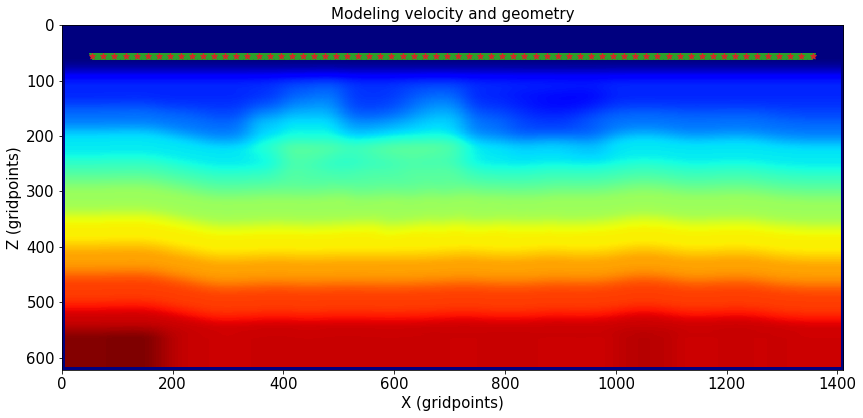

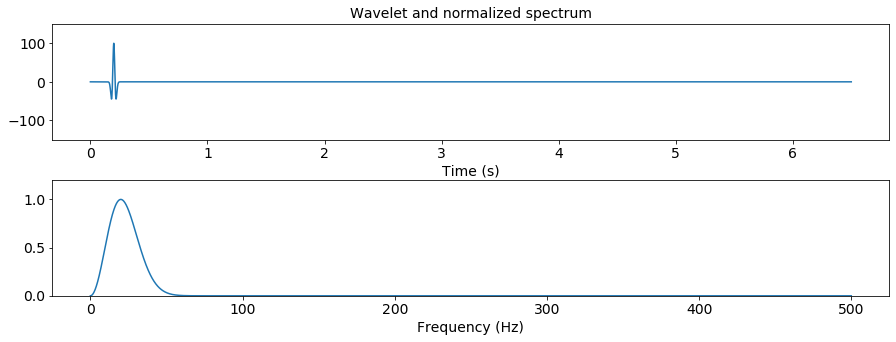

In [4]:
# Acquisition geometry
dsx = 20; bx = 50; bz = 50
prp = geom.defaultgeom(nx,dx,nz,dz,nsx=66,dsx=dsx,bx=bx,bz=bz)
prp.plot_acq(veltru,cmap='jet',show=False,labelsize=15,
             title='Modeling velocity and geometry') # Sources are stars and receivers are triangles

# Create data axes
ntu = 6500; dtu = 0.001;
freq = 20; amp = 100.0; dly = 0.2;
wav = ricker(ntu,dtu,freq,amp,dly)
plot_wavelet(wav,dtu,hspace=0.35,title='Wavelet and normalized spectrum')

## Model the data and create the focused and defocused image

Creating data. This may take a few minutes...
For all examples, check terminal from where you started the notebook for a progress bar
Creating focused image...
Creating poorly focused image...


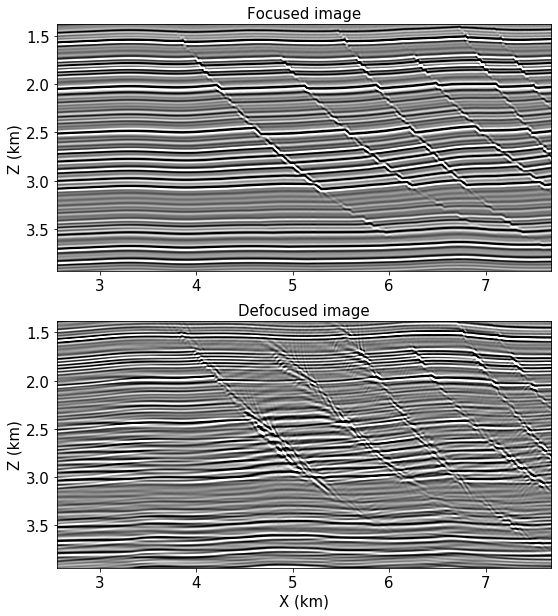

In [5]:
# Model linearized (Born) data
dtd = 0.008 # data sampling interval
print("Creating data. This may take a few minutes...",flush=True)
print("For all examples, check terminal from where you started the notebook for a progress bar",flush=True)
allshot = prp.model_lindata(veltru,ref,wav,dtd,verb=True,nthrds=24)

# Taper for migration
prp.build_taper(70,150)

# Wave equation depth migration
print("Creating focused image...",flush=True)
imgr = prp.wem(veltru,allshot,wav,dtd,nh=nh,lap=True,verb=True,nthrds=24) # NOTE: Use fewer threads if you have less
print("Creating poorly focused image...",flush=True)                      #       than 70 GB of RAM
imgw = prp.wem(velmig,allshot,wav,dtd,nh=nh,lap=True,verb=True,nthrds=24)
nh,oh,dh = prp.get_off_axis()

# Window to the region of interest
nxw = 512; fxw = 256
imgrw = imgr[:,:,fxw:fxw+nxw]
imgww = imgw[:,:,fxw:fxw+nxw]
lblw  = lbl[:,fxw:fxw+nxw]

# Convert to angle gathers [nh,nz,nx] -> [nx,na,nz]
imgrang = prp.to_angle(imgrw,na=na,verb=True,nthrds=24)
imgwang = prp.to_angle(imgww,na=na,verb=True,nthrds=24)
na,oa,da = prp.get_ang_axis()

# Compute the stacks
imgrstk = agc(np.sum(imgrang,axis=1))
imgwstk = agc(np.sum(imgwang,axis=1))

# Plot the stacked images
fzw = 138; nzw = 256
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(imgrstk[:,fzw:fzw+nzw].T,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,
             extent=[fxw*dxp,(fxw+nxw)*dxp,(fzw+nzw)*dzp,fzw*dzp])
ax[0].set_ylabel('Z (km)',fontsize=fsize)
ax[0].set_title('Focused image',fontsize=fsize)
ax[0].tick_params(labelsize=fsize)
ax[1].imshow(imgwstk[:,fzw:fzw+nzw].T,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,
             extent=[fxw*dxp,(fxw+nxw)*dxp,(fzw+nzw)*dzp,fzw*dzp])
ax[1].set_xlabel('X (km)',fontsize=fsize)
ax[1].set_ylabel('Z (km)',fontsize=fsize)
ax[1].set_title('Defocused image',fontsize=fsize)
ax[1].tick_params(labelsize=fsize)

## Create the residually-defocused image

Padding to size nhp=2049 nmp=1300 nzp=513
Rhos: [0.98388]
nrho: [########################################] 1/1


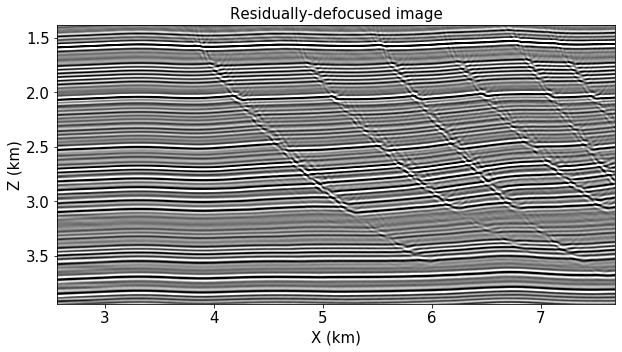

In [6]:
# Residual migration parameters
oro = 1.0; nro = 21; dro = 0.00124

# Compute all of the rhos
foro = oro - (nro-1)*dro; fnro = 2*nro-1
rhos = np.linspace(foro,foro + (fnro-1)*dro,2*nro-1)
# Choose a rho for defocusing
offset = 8
if(np.random.choice([0,1])):
    rho = np.random.randint(0,nro-offset)*dro + foro
else:
    rho = np.random.randint(nro+offset+1,fnro)*dro + foro

# Depth Residual migration for one rho
imgrt = np.transpose(imgr,(0,2,1)) # [nh,nz,nx] -> [nh,nx,nz]
rmig = preresmig(imgrt,[dh,dx,dz],nps=[2049,nx,nz+1],nro=1,oro=rho,dro=dro,time=False,nthreads=1,verb=True)
onro,ooro,odro = get_rho_axis(nro=nro,dro=dro)

# Window to region of interest
rmigw = rmig[:,:,fxw:fxw+nxw:,:]

# Conversion to time
dtd = 0.004
rmigt = convert2time(rmigw,dz,dt=dtd,oro=rho,dro=odro,verb=True)

# Convert to angle
rmigtt = np.ascontiguousarray(np.transpose(rmigt,(0,1,3,2))).astype('float32') # [nro,nh,nx,nz] -> [nro,nh,nz,nx]
rmigang = prp.to_angle(rmigtt,na=na,oro=ooro,dro=odro,verb=True,nthrds=24)

# Plot the residually-defocused stack
rmigstk = agc(np.sum(rmigang,axis=1))
fig = plt.figure(figsize=(10,10)); ax = fig.gca()
ax.imshow(rmigstk[:,fzw:fzw+nzw].T,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,
             extent=[fxw*dxp,(fxw+nxw)*dxp,(fzw+nzw)*dzp,fzw*dzp])
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.set_title('Residually-defocused image',fontsize=fsize)
plt.show()

## Split the images into overlapping patches

I divide the images into patches, where the patch size is 64 and the overlap is 50% in each spatial direction. This gives a total of 105 patches per image. The cell below provides figures that show each of these patch grids.

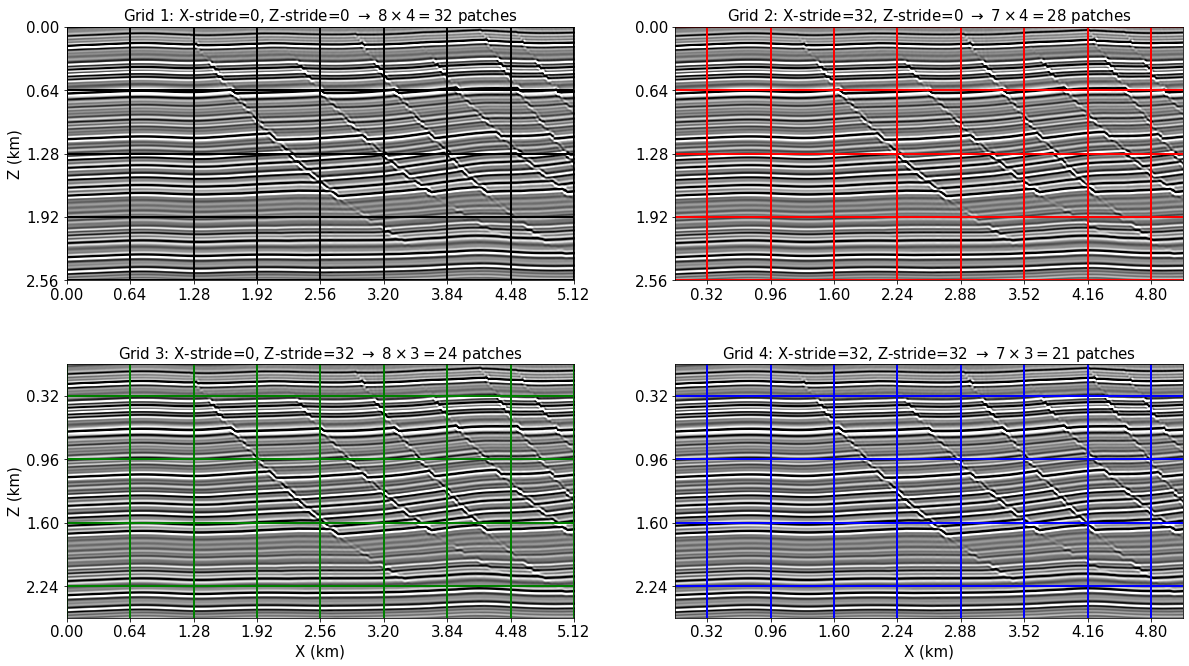

In [7]:
# Define the spatial patch size and stride
ptchz = 64; ptchx = 64
strdz = int(ptchz/2); strdx = int(ptchx/2) 

# Apply AGC to the extended images and transpose [nx,na,nz] -> [na,nz,nx]
imgrangg = np.transpose(agc(imgrang)[:,:,fzw:fzw+nzw],(1,2,0)) 
imgwangg = np.transpose(agc(imgwang)[:,:,fzw:fzw+nzw],(1,2,0))
rmigangg = np.transpose(agc(rmigang)[:,:,fzw:fzw+nzw],(1,2,0))

tptch = normextract(imgrangg,nzp=ptchz,nxp=ptchx,strdz=strdz,strdx=strdx,norm=True) # Focused image
wptch = normextract(imgwangg,nzp=ptchz,nxp=ptchx,strdz=strdz,strdx=strdx,norm=True) # Defocused image
rptch = normextract(rmigangg,nzp=ptchz,nxp=ptchx,strdz=strdz,strdx=strdx,norm=True) # Residually-defocused image
lptch = normextract(lbl[fzw:fzw+nzw,fxw:fxw+nxw],nzp=ptchz,nxp=ptchx,strdz=strdz,strdx=strdx,norm=False) # Fault labels

# Plot the patch grids
bgz = 0; egz = nzw*dzp+1; dgz = ptchz*dzp
bgx = 0; egx = nxw*dxp+1; dgx = ptchx*dxp

imgrwnd = imgrstk[:,fzw:fzw+nzw].T

fig,ax = plt.subplots(2,2,figsize=(20,20))
zticks = np.arange(bgz,egz,dgz)
xticks = np.arange(bgx,egx,dgx)
ax[0,0].set_xticks(xticks)
ax[0,0].set_yticks(zticks)
ax[0,0].imshow(imgrwnd,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,extent=[0,(512)*dxp,(nzw)*dzp,0])
ax[0,0].grid(linestyle='-',color='k',linewidth=2)
ax[0,0].set_ylabel('Z (km)',fontsize=fsize)
ax[0,0].set_title(r'Grid 1: X-stride=0, Z-stride=0 $\rightarrow \,\, 8\times4 =  32$ patches',fontsize=fsize)
ax[0,0].tick_params(labelsize=fsize)

zticks = np.arange(bgz,egz,dgz)
xticks = np.arange(bgx+strdx*dxp,egx-strdx*dxp,dgx)
ax[0,1].set_xticks(xticks)
ax[0,1].set_yticks(zticks)
ax[0,1].imshow(imgrwnd,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,extent=[0,(512)*dxp,(nzw)*dzp,0])
ax[0,1].grid(which='major',linestyle='-',color='r',linewidth=2)
ax[0,1].set_title(r'Grid 2: X-stride=32, Z-stride=0 $\rightarrow \,\, 7\times4 = 28$ patches',fontsize=fsize)
ax[0,1].tick_params(labelsize=fsize)

zticks = np.arange(bgz+strdz*dzp,egz-strdz*dzp,dgz)
xticks = np.arange(bgx,egx,dgx)
ax[1,0].set_xticks(xticks)
ax[1,0].set_yticks(zticks)
ax[1,0].imshow(imgrwnd,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,extent=[0,(512)*dxp,(nzw)*dzp,0])
ax[1,0].grid(which='major',linestyle='-',color='g',linewidth=2)
ax[1,0].set_ylabel('Z (km)',fontsize=fsize)
ax[1,0].set_xlabel('X (km)',fontsize=fsize)
ax[1,0].set_title(r'Grid 3: X-stride=0, Z-stride=32 $\rightarrow \,\, 8\times3 = 24$ patches',fontsize=fsize)
ax[1,0].tick_params(labelsize=fsize)

zticks = np.arange(bgz+strdz*dzp,egz-strdz*dzp,dgz)
xticks = np.arange(bgx+strdx*dxp,egx-strdx*dxp,dgx)
ax[1,1].set_xticks(xticks)
ax[1,1].set_yticks(zticks)
ax[1,1].imshow(imgrwnd,cmap='gray',interpolation='sinc',vmin=-2.5,vmax=2.5,extent=[0,512*dxp,nzw*dzp,0])
ax[1,1].grid(which='major',linestyle='-',color='b',linewidth=2)
ax[1,1].set_xlabel('X (km)',fontsize=fsize)
ax[1,1].set_title(r'Grid 4: X-stride=32, Z-stride=32 $\rightarrow \,\, 7\times3 = 21$ patches',fontsize=fsize)
ax[1,1].tick_params(labelsize=fsize)
plt.subplots_adjust(hspace=-0.55)

## Label the images as focused or defocused

The final step is to label each of the patches as focused or unfocused. For the focused image and the residually-defocused image this is trivial as each patch in the entire image can be considered focused or defocused respectively. For the defocused image (created by migrating with a velocity anomaly) I compute three metrics for each patch. The first two are cross correlation image similarity metrics. I compute this metric between the focused and defocused image and between the focused fault segmentations and the defocused fault segementations. Based on these metrics I define a threshold that allows me to discriminate between focused and unfocused patches. 
For the other metric, I compute the power of the stack (semblance) over the angle gather patch. If it is above a specific threshold, I don't use it. Otherwise, it is considered defocused.

Note that this approach for labeling is not exact and it is possible that focused patches could be labeled as defocused. For this reason, I err on the side of caution and discard any patches that are above the threshold and only use those that I feel confident are not focused

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None

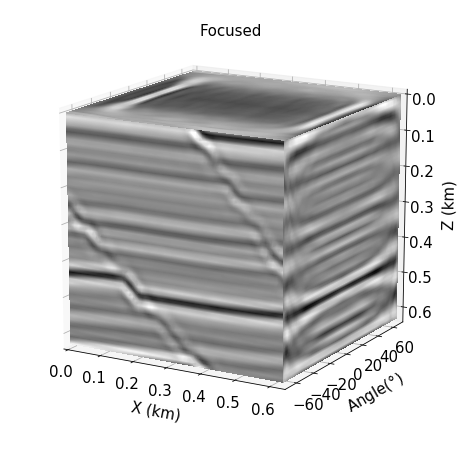

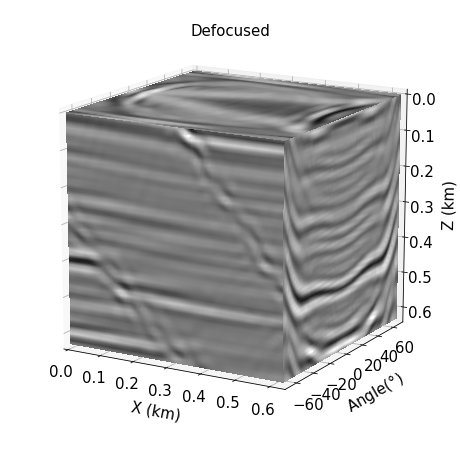

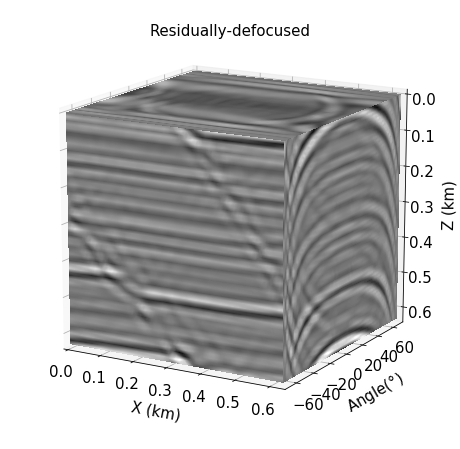

In [8]:
# Download the network architecture
arch = "migfltseg_arch.json"
if(not os.path.exists(arch)):
    url  = "http://sep.stanford.edu/data/media/public/sep/joseph29/resfoc/networks/migfltseg_arch.json"
    arch = wget.download(url)
wgts = "migfltseg_wgts.h5"
if(not os.path.exists(wgts)):
    url = "http://sep.stanford.edu/data/media/public/sep/joseph29/resfoc/networks/migfltseg_wgts.h5"
    wgts = wget.download(url)

# Get GPU to use
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

# Load in the fault segmentation network
with open(arch,'r') as f:
    model = model_from_json(f.read())
model.load_weights(wgts)
model.summary()

# Make predictions on the focused and defocused stacks
tptchstk = np.expand_dims(np.sum(tptch,axis=1),axis=-1)
wptchstk = np.expand_dims(np.sum(wptch,axis=1),axis=-1)

focprb = model.predict(tptchstk,verbose=1)
defprb = model.predict(wptchstk,verbose=1)

# Total number of patches
nex = focprb.shape[0]

# Thresholds
pixthresh = 20 # number of fault pixels to determine if patch has fault
thresh1 = 0.7
thresh2 = 0.5
thresh3 = 0.7
# Output defocused images 
defout = []
# Loop over all patches and select defocused patches
for iex in progressbar(range(nex), "nsim:"):
    # Compute fault metrics
    fltnum = np.sum(lptch[iex,:,:])
    # If example has faults, use fault criteria
    if(fltnum > pixthresh):
        corrimg = corrsim(tptchstk[iex,:,:,0],wptchstk[iex,:,:,0])
        corrprb = corrsim(defprb[iex,:,:,0],focprb[iex,:,:,0])
        if(corrimg < thresh1 and corrprb < thresh1):
            defout.append(wptch[iex])
        elif(corrimg < thresh2 or corrprb < thresh2):
            defout.append(wptch[iex])
    else:
        # Compute angle metrics
        fsemb = semblance_power(tptch[iex])
        dsemb = semblance_power(wptch[iex])
        sembrat = dsemb/fsemb
        if(sembrat < thresh3):
            defout.append(wptch[iex])

defout = np.asarray(defout)
print("Keeping def=%d examples"%(defout.shape[0]))

# Plot the labled patches
iex = 43
plot_cubeiso(tptch[iex],os=[-70.0,0,0],ds=[da,dzp,dxp],stack=True,show=True,hbox=8,wbox=8,elev=15,
                 x1label='\nX (km)',x2label='\nAngle'+r'($\degree$)',x3label='\nZ (km)',verb=False,title='Focused')
plot_cubeiso(defout[iex],os=[-70.0,0,0],ds=[da,dzp,dxp],stack=True,show=True,hbox=8,wbox=8,elev=15,
                 x1label='\nX (km)',x2label='\nAngle'+r'($\degree$)',x3label='\nZ (km)',verb=False,title='Defocused')
plot_cubeiso(rptch[iex],os=[-70.0,0,0],ds=[da,dzp,dxp],stack=True,show=True,hbox=8,wbox=8,elev=15,
                 x1label='\nX (km)',x2label='\nAngle'+r'($\degree$)',x3label='\nZ (km)',verb=False,
                 title='Residually-defocused')